In [10]:
using DataFrames, CSV, PyPlot, PorousMaterials

PyPlot.matplotlib.style.use("Solarize_Light2")

# methane adsorption HKUST-1 and MOF-5
read in adsorption data, covert uptake to mmol/g

In [15]:
mofs = ["HKUST-1", "MOF-5"]
df = Dict{String, DataFrame}()
for mof in mofs
    df[mof] = CSV.read("ch4_" * mof * "_25C.csv", comment="#")
    df[mof][!, :N_mmol_g] = df[mof][:, Symbol("N(cm3/g)")] / 22.4
end
first(df[mofs[1]], 3)

,P(bar),N(cm3/g),N_mmol_g
,Float64,Float64,Float64
1,0.68,15.52,0.692857
2,1.72,34.43,1.53705
3,3.55,62.79,2.80313


fit Langmuir model

In [16]:
params = Dict(mof => fit_adsorption_isotherm(df[mof], Symbol("P(bar)"), :N_mmol_g, :langmuir) for mof in mofs)

Dict{String,Dict{String,Float64}} with 2 entries:
  "MOF-5"   => Dict("M"=>32.2469,"K"=>0.0139923,"MSE"=>0.0322526)
  "HKUST-1" => Dict("M"=>16.6781,"K"=>0.0600375,"MSE"=>0.00464618)

plot data with Langmuir fit

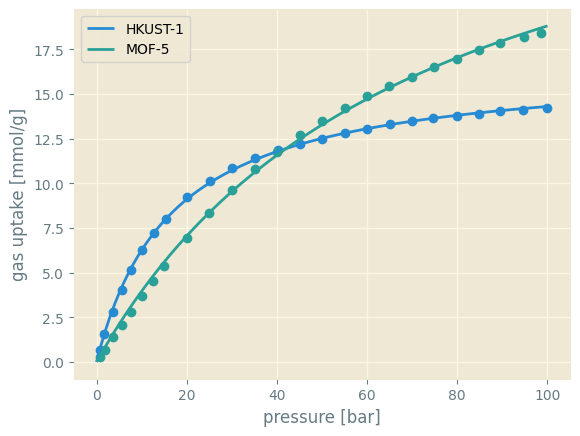

PyObject Text(28.0, 0.5, 'gas uptake [mmol/g]')

In [20]:
figure()
p = range(0.0, 100.0, length=100)
for mof in mofs
    scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :N_mmol_g])
    plot(p, params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p), label=mof)
end
legend()
xlabel("pressure [bar]")
ylabel("gas uptake [mmol/g]")